# Linear Regression: Latitude Transfer and Full Southern Ocean

_Author: Emilio Luz-Ricca_

This notebook contains all code needed to perform the cross-latitude transfer experiments in the Southern Ocean (60S --> all other latitudes), as well as the full Southern Ocean linear regression training (an independent model for each latitude). Read section headings for more details on setup, preprocessing, and model training. Much of the code was adapted from `linear_regression.ipynb`.

# Setup

Loading needed modules and defining some helper functions. Notice that preprocessing and model evaluation are helper functions rather than being present in the model loop, as in `linear_regression.ipynb`.

In [66]:
import sys
import pickle
import os

sys.path.append('..')
from models.utils import *
from models.plotting_utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt
import xarray as xr

In [67]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [68]:
# A helper function to turn numeric latitudes to into strings
def format_lat(lat):
    return str(-1 * lat) + 'S' if lat < 0 else str(lat) + 'N'

In [69]:
# A helper function to compute all relevant metrics
def build_metric_dict(y_test, y_pred, mape_thresh = 0.5):
    metric_dict = {}

    metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
    metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
    metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
    metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)
    
    mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
    pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
    metric_dict['MAPE_thresh'] = f'{round(mape * 100, 3)} (thresh={mape_thresh}, {pct_kept}% kept)'

    return metric_dict

In [70]:
# A helper function to apply preprocessing for a given latitude, both inputs and outputs
def preprocess(inputs, outputs, remove_trend, remove_season, zonal_avg = True, var_subset = None):
    pp_data = apply_preprocessing(inputs, mode = 'inputs', remove_season = remove_season,
                                  remove_trend = remove_trend, standardize = True, lowpass = False)
    data_vars = list(pp_data.keys())
    
    if zonal_avg:
        pp_data_np = reshape_inputs(pp_data, keep_coords = ['time'], data_vars = data_vars)
    elif not zonal_avg and var_subset is not None:
        pp_data = pp_data[var_subset]
        pp_data_np = pp_data.to_array().transpose('time', ...).squeeze().values 
        pp_data_np = pp_data_np.reshape(pp_data_np.shape[0], -1)

        print("axes: ['time', 'feature']")
        print(f'variables: {var_subset}')
        print(f'shape: {pp_data_np.shape}')
    else:
        raise ValueError('If zonal_avg=False, then var_subset must not be None!')

    strength = apply_preprocessing(outputs, mode = 'outputs', remove_season = remove_season,
                                   remove_trend = remove_trend, standardize = False, lowpass = False)
    strength_np = strength.moc.squeeze().values

    X = pp_data_np
    y = strength_np
    
    X = sm.add_constant(X)

    return X, y

# Experiment variables

Defining all variables that are relevant for _both_ of the experiments.

In [71]:
# General experiment variables
data_home = '/Users/emiliolr/Google Drive/My Drive/GTC'

remove_trend = False
remove_season = False

# Experiment 1: Cross-Latitude Transferability

In this experiment, we train a regularised linear regression model (ElasticNet) on 60S and apply it to all other Southern Ocean latitudes (80.5S to 30S) to understand if learned patterns at one latitude are helpful in predicting at other latitudes.

In [72]:
# Experiment-specific variables
lat_for_training = -59.75

In [73]:
# Loading surface variables
southern_ocean = xr.open_dataset(os.path.join(data_home, 'ecco_data_minimal', 'southern_ocean.nc'))
southern_ocean = southern_ocean.dropna('latitude', how = 'all')
southern_ocean = southern_ocean.fillna(0)
southern_ocean

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 102, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -80.25 -79.75 -79.25 ... -30.75 -30.25 -29.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 -1.491 -1.491 ... 0.6051
    ZWS        (time, latitude, longitude) float32 0.0006253 ... -0.05642
    OBP        (time, latitude, longitude) float32 -1.568 -1.568 ... 12.21 12.21
    SSS        (time, latitude, longitude) float32 34.16 34.16 ... 35.81 35.81
    SST        (time, latitude, longitude) float32 0.1538 0.1538 ... 21.72 21.72

In [74]:
# Pulling out some variables of interest
other_lats = list(southern_ocean.latitude.values) # full southern ocean (where not NaN)
other_lats.remove(lat_for_training)

lats = sorted(list(southern_ocean.latitude.values))

In [75]:
# Load in response var for all relevant latitudes
moc_all_lats = []

for lat in lats:
    lat_str = format_lat(lat)
    moc_fp = f'{data_home}/ecco_data_minimal/southern_ocean_moc/{lat_str}_moc.pickle'

    with open(moc_fp, 'rb') as f:
        moc = pickle.load(f)

    moc_all_lats.append(moc)

moc_all_lats = np.array(moc_all_lats)
moc_all_lats = xr.Dataset(data_vars = {'moc' : (['latitude', 'time'], moc_all_lats)}, 
                          coords = {'time' : southern_ocean.time, 'latitude' : lats})
moc_all_lats

<xarray.Dataset>
Dimensions:   (latitude: 102, time: 312)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) float32 -80.25 -79.75 -79.25 ... -30.75 -30.25 -29.75
Data variables:
    moc       (latitude, time) float64 -0.0 -0.0 -0.0 ... -16.38 -20.23 -23.15

In [76]:
# Training a linear regression model on 60S
inputs = southern_ocean.sel(latitude = lat_for_training).expand_dims({'latitude' : 1})
outputs = moc_all_lats.sel(latitude = lat_for_training).expand_dims({'latitude' : 1})

# Preprocessing all inputs
X, y = preprocess(inputs, outputs, remove_trend, remove_season, zonal_avg = True)

#  train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, 
                                                    stratify = None, random_state = 123456)

# Define the hyperparameters to optimize over
param_grid = {
    'alpha' : np.logspace(-4, 4, 10),
    'L1_wt' : np.linspace(0, 1, 10)
}

# TRAINING: grid search with cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv = 10, scoring = 'neg_mean_squared_error', verbose = 1)
grid_search.fit(X_train, y_train)

#  report best result
print(f'Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}')

#  calculate test performance for 60S
y_pred_60S = grid_search.best_estimator_.predict(X_test)
metric_dict_60S = build_metric_dict(y_test, y_pred_60S)
print(metric_dict_60S)

axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best MSE (cross-validation): 15.95
{'R^2': 0.446, 'MSE': 29.862, 'RMSE': 5.465, 'MAE': 4.689, 'MAPE': 85.273, 'MAPE_thresh': '85.266 (thresh=0.5, 100.0% kept)'}


In [77]:
# Extending the 60S model to the rest of the southern ocean
just_test_period = False
meta_metric_dict = {'RMSE' : [], 'MAE' : [], 'R^2' : [], 'MAPE' : []}

for lat in lats:
    print(f'PREDICTING ON LATITUDE {format_lat(lat)}')
    
    X = southern_ocean.sel(latitude = lat).expand_dims({'latitude' : 1})
    y = moc_all_lats.sel(latitude = lat).expand_dims({'latitude' : 1})

    X, y = preprocess(X, y, remove_trend, remove_season, zonal_avg = True)

    y_pred = grid_search.best_estimator_.predict(X)

    if just_test_period:
        metric_dict = build_metric_dict(y[len(X_train) : ], y_pred[len(X_train) : ])
    else:
        metric_dict = build_metric_dict(y, y_pred)
    
    for metric in meta_metric_dict:
        meta_metric_dict[metric].append(metric_dict[metric])

    print('------')

PREDICTING ON LATITUDE 80.25S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 79.75S


/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 79.25S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 78.75S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 78.25S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 77.75S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 77.25S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 76.75S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE 76.25S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
PREDICTING ON LATITUDE

In [80]:
# A bit of cleanup to remove ridiculous results for MAPE and R^2
for k in meta_metric_dict:
    meta_metric_dict[k] = np.array(meta_metric_dict[k])

MAPE_cutoff = 1000
R2_cutoff = -1

meta_metric_dict['MAPE'][meta_metric_dict['MAPE'] > MAPE_cutoff] = np.nan
meta_metric_dict['R^2'][meta_metric_dict['R^2'] < R2_cutoff] = np.nan

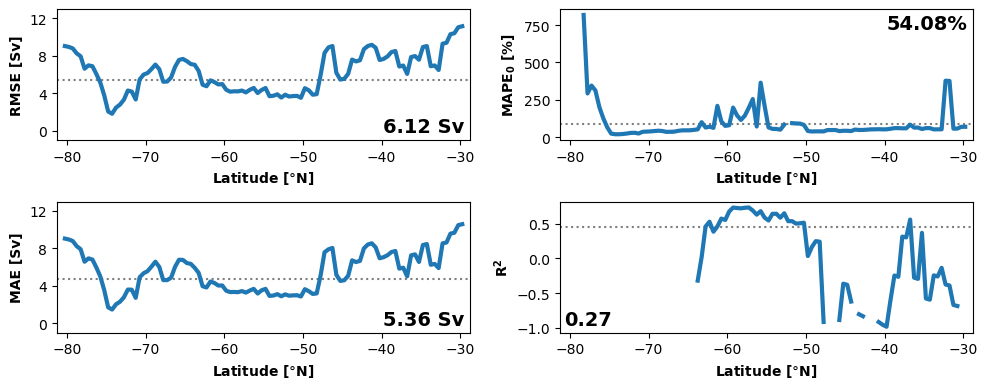

In [102]:
# Plotting the performance as a function of latitude in the southern ocean
fig, ax = plt.subplots(2, 2, figsize = (10, 4))

i, j = 0, 0
alt = True
for metric in meta_metric_dict:
    med_val = round(np.nanmedian(meta_metric_dict[metric]), 2)
    
    ax[i, j].axhline(metric_dict_60S[metric], linestyle = ':', color = 'black', alpha = 0.5, zorder = 0) 
    ax[i, j].plot(lats, meta_metric_dict[metric], linewidth = 3, zorder = 50)
    
    if metric == 'R^2':
        y_label = 'R$\\mathbf{^2}$'
        ax[i, j].annotate(f'{med_val}', xy = (0.01, 0.06), xycoords = 'axes fraction', 
                          fontsize = 14, weight = 'bold')
    elif metric == 'MAPE':
        y_label = 'MAPE$\\mathbf{_0}$ [%]'
        ax[i, j].annotate(f'{med_val}%', xy = (0.79, 0.85), xycoords = 'axes fraction', 
                          fontsize = 14, weight = 'bold')
    else:
        y_label = metric + ' [Sv]'
        ax[i, j].annotate(f'{med_val} Sv', xy = (0.79, 0.06), xycoords = 'axes fraction', 
                          fontsize = 14, weight = 'bold')

        ax[i, j].set_ylim(-1, 13)
        ax[i, j].yaxis.set_ticks([0, 4, 8, 12])
    
    ax[i, j].set_ylabel(y_label, weight = 'bold')
    ax[i, j].set_xlabel('Latitude [$\\degree$N]', weight = 'bold')

    plt_bounds = southern_ocean.latitude.values.min() - 1, southern_ocean.latitude.values.max() + 1
    ax[i, j].set_xlim(plt_bounds)

    if alt:
        alt = False
        i = (i + 1) % 2
    else:
        alt = True
        j = (j + 1) % 2

plt.tight_layout()
plt.savefig(f'/Users/emiliolr/Desktop/regression_results/linear_regression_transfer_all_metrics.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [82]:
# Calculating the median for each test metric
for metric in meta_metric_dict:
    med_val = round(np.nanmedian(meta_metric_dict[metric]), 3)
    mean_val = round(np.nanmean(meta_metric_dict[metric]), 3)
    
    print(f'Median {metric}: {med_val}')
    print(f'Mean {metric}: {mean_val}')
    print()

Median RMSE: 6.123
Mean RMSE: 6.195

Median MAE: 5.363
Mean MAE: 5.501

Median R^2: 0.274
Mean R^2: 0.068

Median MAPE: 54.081
Mean MAPE: 91.61



# Experiment 2: Full Southern Ocean

In this experiment, we train a regularised linear regression model (ElasticNet) independently on each latitude in the Southern Ocean (80.5S to 30S) to understand the latitudes at which it is hardest to predict the MOC strength. Much of the code is repeated or adapted from Experiment 1 to ensure this experiment is self-contained (i.e., can be run without having to interact with Experiment 1 variables).

In [103]:
# Experiment-specific variables
zonal_avg = False
cv_folds = 4
param_levels = 2
var_subset = ['OBP']

save_fp = '/Users/emiliolr/Desktop/regression_results/performance_vs_latitude_linear_regression_full_zonal.pickle'

In [104]:
# Getting surface vars for all lats
southern_ocean = xr.open_dataset(os.path.join(data_home, 'ecco_data_minimal', 'southern_ocean.nc'))
southern_ocean = southern_ocean.dropna('latitude', how = 'all')
southern_ocean = southern_ocean.fillna(0)

lats = southern_ocean.latitude.values

# Getting streamfunc for all lats
moc_all_lats = []

for lat in lats:
    lat_str = format_lat(lat)
    moc_fp = f'{data_home}/ecco_data_minimal/southern_ocean_moc/{lat_str}_moc.pickle'

    with open(moc_fp, 'rb') as f:
        moc = pickle.load(f)

    moc_all_lats.append(moc)

moc_all_lats = np.array(moc_all_lats)
moc_all_lats = xr.Dataset(data_vars = {'moc' : (['latitude', 'time'], moc_all_lats)}, 
                          coords = {'time' : southern_ocean.time, 'latitude' : lats})

In [31]:
# Training a linear regression on each lat independently
meta_metric_dict = {'RMSE' : [], 'MAE' : [], 'R^2' : [], 'MAPE' : []}

for lat in lats:
    print(f'Training on {format_lat(lat)}...')
    
    inputs = southern_ocean.sel(latitude = lat).expand_dims({'latitude' : 1})
    outputs = moc_all_lats.sel(latitude = lat).expand_dims({'latitude' : 1})
    
    # Preprocessing all inputs
    X, y = preprocess(inputs, outputs, remove_trend, remove_season, zonal_avg = zonal_avg, var_subset = var_subset)
    
    #  train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, 
                                                        stratify = None, random_state = 123456)
    
    # Define the hyperparameters to optimize over
    param_grid = {
        'alpha' : np.logspace(-4, 4, param_levels),
        'L1_wt' : np.linspace(0, 1, param_levels)
    }
    
    # TRAINING: grid search with cross-validation
    grid_search = GridSearchCV(SMWrapper(), param_grid, cv = cv_folds, scoring = 'neg_mean_squared_error', verbose = 0)
    grid_search.fit(X_train, y_train)
    
    #  calculate test performance for 60S
    y_pred = grid_search.best_estimator_.predict(X_test)
    metric_dict = build_metric_dict(y_test, y_pred)

    #  add to collection of metric dictionaries
    for metric in meta_metric_dict:
        meta_metric_dict[metric].append(metric_dict[metric])

    print('------')

Training on 80.25S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)


/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


------
Training on 79.75S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)


/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


------
Training on 79.25S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 78.75S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 78.25S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 77.75S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 77.25S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 76.75S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 76.25S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 75.75S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 75.25S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 74.75S...
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 720)
------
Training on 74.25S...
axes: ['time', 'feature']
variables: ['OBP']
shape:

In [ ]:
# Saving results just in case, since the last cell takes a long time to run
with open(save_fp, 'wb') as f:
    pickle.dump(meta_metric_dict, f)

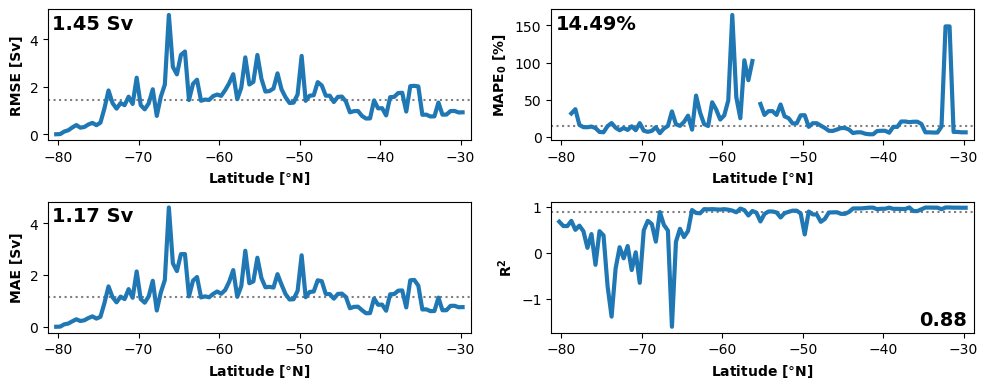

In [107]:
# Plotting the performance as a function of latitude in the southern ocean
with open(save_fp, 'rb') as f:
    meta_metric_dict = pickle.load(f)

for metric in meta_metric_dict:
    meta_metric_dict[metric] = np.array(meta_metric_dict[metric])
meta_metric_dict['MAPE'][meta_metric_dict['MAPE'] > 500] = np.nan

fig, ax = plt.subplots(2, 2, figsize = (10, 4))

i, j = 0, 0
alt = True
for metric in meta_metric_dict:  
    med_val = round(np.nanmedian(meta_metric_dict[metric]), 2)
    ax[i, j].axhline(med_val, linestyle = ':', color = 'black', zorder = 0, alpha = 0.5)
    ax[i, j].plot(lats, meta_metric_dict[metric], linewidth = 3, zorder = 10)

    if metric == 'R^2':
        y_label = 'R$\\mathbf{^2}$'
        ax[i, j].annotate(f'{med_val}', xy = (0.87, 0.06), xycoords = 'axes fraction', 
                          fontsize = 14, weight = 'bold')
    elif metric == 'MAPE':
        y_label = 'MAPE$\\mathbf{_0}$ [%]'
        ax[i, j].annotate(f'{med_val}%', xy = (0.01, 0.85), xycoords = 'axes fraction', 
                          fontsize = 14, weight = 'bold')
    else:
        y_label = metric + ' [Sv]'
        ax[i, j].annotate(f'{med_val} Sv', xy = (0.01, 0.85), xycoords = 'axes fraction', 
                          fontsize = 14, weight = 'bold')
    
    ax[i, j].set_xlabel('Latitude [$\\degree$N]', weight = 'bold')
    ax[i, j].set_ylabel(y_label, weight = 'bold')

    plt_bounds = lats.min() - 1, lats.max() + 1
    ax[i, j].set_xlim(plt_bounds)

    if alt:
        alt = False
        i = (i + 1) % 2
    else:
        alt = True
        j = (j + 1) % 2

plt.tight_layout()
plt.savefig(f'/Users/emiliolr/Desktop/regression_results/linear_regression_all_lats_all_metrics.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [108]:
# Checking 60S metrics against expected - slightly different, but full southern ocean MOC 
#   slightly different as compared to the ones Sharan produced just one lat at a time
idx = np.argwhere(lats == -59.75)[0, 0]

for metric in meta_metric_dict:
    print(f'60S {metric}: {meta_metric_dict[metric][idx]}')

60S RMSE: 1.618
60S MAE: 1.274
60S R^2: 0.951
60S MAPE: 28.909


In [109]:
# Calculating the median for each test metric
for metric in meta_metric_dict:
    med_val = round(np.nanmedian(meta_metric_dict[metric]), 3)
    mean_val = round(np.nanmean(meta_metric_dict[metric]), 3)
    
    print(f'Median {metric}: {med_val}')
    print(f'Mean {metric}: {mean_val}')
    print()

Median RMSE: 1.446
Mean RMSE: 1.493

Median MAE: 1.17
Mean MAE: 1.238

Median R^2: 0.882
Mean R^2: 0.672

Median MAPE: 14.494
Mean MAPE: 23.882

